# **Big Data Project**

#**1. Pyspark**

In [ ]:
!pip install pyspark

In [ ]:
#Importing the required libraries

import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt
from pyspark import SparkContext
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import col, mean , desc, when,count,sum, lit, abs
from pyspark.sql.types import IntegerType, FloatType, DoubleType, StringType
from pyspark.ml.classification import NaiveBayes , RandomForestClassificationModel, DecisionTreeClassifier, RandomForestClassifier, MultilayerPerceptronClassifier , GBTClassifier
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from pyspark.sql import functions as F
import math

spark = SparkSession\
        .builder\
        .master('local[*]')\
        .getOrCreate()
sc = spark.sparkContext

In [ ]:
#Loading and previewing the dataset

transactions_df = spark.read.csv('/content/sample_data/train_transaction.csv', header=True, inferSchema=True)
transactions_df.show(10)

+-------------+-------+-------------+--------------+---------+-----+-----+-----+----------+-----+------+-----+-----+-----+-----+-------------+-------------+---+---+---+---+---+---+---+---+---+---+---+---+----+---+-----+-----+----+-----+----+----+----+----+----+----+-----+----+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+----+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+------+-----+----+-----+-----+----

In [ ]:
# Findimg the number of rowns and columns

num_rows = transactions_df.count()
num_columns = len(transactions_df.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")


Number of rows: 13788
Number of columns: 394


In [ ]:
#Checks the data type of the data

schema_fields = transactions_df.schema.fields
schema_fields

[StructField('TransactionID', IntegerType(), True),
 StructField('isFraud', IntegerType(), True),
 StructField('TransactionDT', IntegerType(), True),
 StructField('TransactionAmt', DoubleType(), True),
 StructField('ProductCD', StringType(), True),
 StructField('card1', IntegerType(), True),
 StructField('card2', DoubleType(), True),
 StructField('card3', DoubleType(), True),
 StructField('card4', StringType(), True),
 StructField('card5', DoubleType(), True),
 StructField('card6', StringType(), True),
 StructField('addr1', DoubleType(), True),
 StructField('addr2', DoubleType(), True),
 StructField('dist1', DoubleType(), True),
 StructField('dist2', DoubleType(), True),
 StructField('P_emaildomain', StringType(), True),
 StructField('R_emaildomain', StringType(), True),
 StructField('C1', DoubleType(), True),
 StructField('C2', DoubleType(), True),
 StructField('C3', DoubleType(), True),
 StructField('C4', DoubleType(), True),
 StructField('C5', DoubleType(), True),
 StructField('C6',

In [ ]:
# Finds column information

num_double_columns = len([field.name for field in schema_fields if isinstance(field.dataType, DoubleType)])
num_string_columns = len([field.name for field in schema_fields if isinstance(field.dataType, StringType)])
num_integer_columns = len([field.name for field in schema_fields if isinstance(field.dataType, IntegerType)])

double_columns = [field.name for field in transactions_df.schema.fields if isinstance(field.dataType, DoubleType)]
string_columns = [field.name for field in transactions_df.schema.fields if isinstance(field.dataType, StringType)]
integer_columns = [field.name for field in transactions_df.schema.fields if isinstance(field.dataType, IntegerType)]

print(f"DoubleType Columns: {num_double_columns}")
print(double_columns)

print(f"\nStringType Columns: {num_string_columns}")
print(string_columns)

print(f"\nIntegerType Columns: {num_integer_columns}")
print(integer_columns)



DoubleType Columns: 376
['TransactionAmt', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', '

In [ ]:
#Converting double columns to int

int_columns = double_columns

for column in int_columns:
    transactions_df = transactions_df.withColumn(column, col(column).cast(IntegerType()))

In [ ]:
# Fills missing values with the mean of the colunm (int) and 'unknown' for string colunms


mean_values = transactions_df.select(
    *[mean(col(column)).alias(column) for column in int_columns]
).collect()[0]

mean_dict = {column: mean_values[column] for column in int_columns if mean_values[column] is not None}

string_fill_dict = {column: "unknown" for column in string_columns}

fill_values = {**mean_dict, **string_fill_dict}

transactions_df = transactions_df.fillna(fill_values)

transactions_df.show()


+-------------+-------+-------------+--------------+---------+-----+-----+-----+----------+-----+------+-----+-----+-----+-----+-------------+-------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+-------+-------+-------+-------+-------+-------+-------+-------+-------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+

In [ ]:
# Check for negative values in integer columns

negative_counts = transactions_df.select(
  [count(when(col(column) < 0, column)).alias(f"{column}_negative") for column in int_columns]

)
print(negative_counts.columns)
total_neg_values = len(negative_counts.columns)
print(f"The dataset has {total_neg_values} negative values ")
print()
negative_counts.show()


['TransactionAmt_negative', 'card2_negative', 'card3_negative', 'card5_negative', 'addr1_negative', 'addr2_negative', 'dist1_negative', 'dist2_negative', 'C1_negative', 'C2_negative', 'C3_negative', 'C4_negative', 'C5_negative', 'C6_negative', 'C7_negative', 'C8_negative', 'C9_negative', 'C10_negative', 'C11_negative', 'C12_negative', 'C13_negative', 'C14_negative', 'D1_negative', 'D2_negative', 'D3_negative', 'D4_negative', 'D5_negative', 'D6_negative', 'D7_negative', 'D8_negative', 'D9_negative', 'D10_negative', 'D11_negative', 'D12_negative', 'D13_negative', 'D14_negative', 'D15_negative', 'V1_negative', 'V2_negative', 'V3_negative', 'V4_negative', 'V5_negative', 'V6_negative', 'V7_negative', 'V8_negative', 'V9_negative', 'V10_negative', 'V11_negative', 'V12_negative', 'V13_negative', 'V14_negative', 'V15_negative', 'V16_negative', 'V17_negative', 'V18_negative', 'V19_negative', 'V20_negative', 'V21_negative', 'V22_negative', 'V23_negative', 'V24_negative', 'V25_negative', 'V26_nega

In [ ]:
# Replacing negative values with their absolute value

transactions_df = transactions_df.select(
    *[abs(col(column)).alias(column) if column in int_columns else col(column) for column in transactions_df.columns]
)


print(f"The dataset has {len(int_columns)} integer columns transformed to absolute values.")
transactions_df.show()


The dataset has 376 integer columns transformed to absolute values.
+-------------+-------+-------------+--------------+---------+-----+-----+-----+----------+-----+------+-----+-----+-----+-----+-------------+-------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+-------+-------+-------+-------+-------+-------+-------+-------+-------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+--

In [ ]:
#Finding all genuine transations

genuine_transactions = transactions_df.filter(col('isFraud') == 0)
print(f"The dataset has {genuine_transactions.count()} genuine transactions")
genuine_transactions.show()


The dataset has 13408 genuine transactions
+-------------+-------+-------------+--------------+---------+-----+-----+-----+----------+-----+------+-----+-----+-----+-----+-------------+-------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+-------+-------+-------+-------+-------+-------+-------+-------+-------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+--

In [ ]:
#Finding all fradualent transations

fraudulent_transactions = transactions_df.filter(col('isFraud') == 1)
print(f"The dataset has {fraudulent_transactions.count()} fradulent transactions")
fraudulent_transactions.show()


The dataset has 380 fradulent transactions
+-------------+-------+-------------+--------------+---------+-----+-----+-----+----------+-----+------+-----+-----+-----+-----+-------------+-------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+-------+-------+-------+-------+-------+-------+-------+-------+-------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+--

In [ ]:
# Finding the count of genuine and fradulent transactions alnong with the percentage

fraud_counts = transactions_df.groupBy("isFraud").count()
total_transactions = transactions_df.count()
fraud_counts_with_percentage = fraud_counts.withColumn(
    "percentage",
    (col("count") / total_transactions) * 100
)


fraud_counts_with_percentage.show()


+-------+-----+------------------+
|isFraud|count|        percentage|
+-------+-----+------------------+
|      1|  380|2.7560197272991007|
|      0|13408| 97.24398027270091|
+-------+-----+------------------+



   isFraud  count
0        1    380
1        0  13408



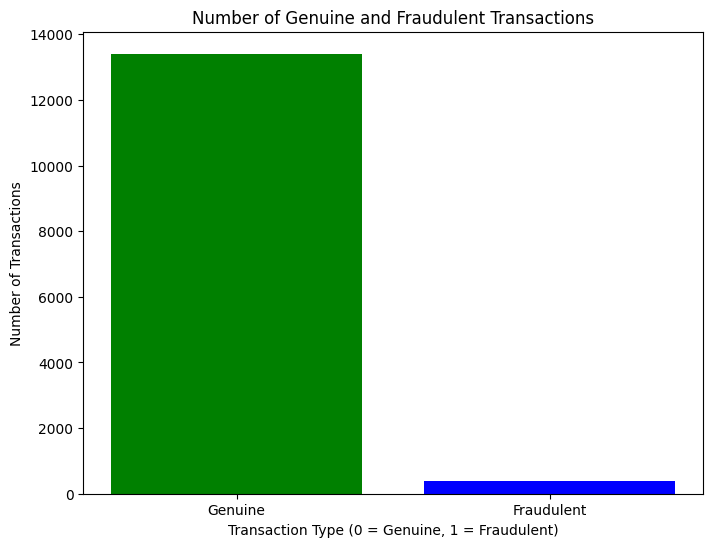

In [ ]:
# Plots the genuine and fradulent transactions

fraud_counts_df = fraud_counts.toPandas()
print(fraud_counts_df)
print()

plt.figure(figsize=(8, 6))
plt.bar(fraud_counts_df["isFraud"], fraud_counts_df["count"], color=["Blue", "Green"])
plt.title("Number of Genuine and Fraudulent Transactions")
plt.xlabel("Transaction Type (0 = Genuine, 1 = Fraudulent)")
plt.ylabel("Number of Transactions")
plt.xticks([0, 1], labels=["Genuine", "Fraudulent"])
plt.show()



In [ ]:
#Finds the card types used in the dataset and which ones were used in fradulent transactions

card_stats = transactions_df.groupBy("card4").agg(
    count("*").alias("number_of_transactions"),
    count(when(col("isFraud") == 0, 1)).alias("genuine_transactions"),
    count(when(col("isFraud") == 1, 1)).alias("fraudulent_transactions")
)


card_stats.show(truncate=False)

fraudulent_card_counts = transactions_df.filter(col("isFraud") == 1).groupBy("card4").count()
most_fraudulent_card = fraudulent_card_counts.orderBy(desc("count")).first()
print(f"The card type with the most fraudulent transactions is: {most_fraudulent_card['card4']} with {most_fraudulent_card['count']} fraudulent transactions.")



+----------------+----------------------+--------------------+-----------------------+
|card4           |number_of_transactions|genuine_transactions|fraudulent_transactions|
+----------------+----------------------+--------------------+-----------------------+
|mastercard      |4795                  |4637                |158                    |
|american express|159                   |157                 |2                      |
|discover        |143                   |137                 |6                      |
|visa            |8688                  |8474                |214                    |
|unknown         |3                     |3                   |0                      |
+----------------+----------------------+--------------------+-----------------------+

The card type with the most fraudulent transactions is: visa with 214 fraudulent transactions.


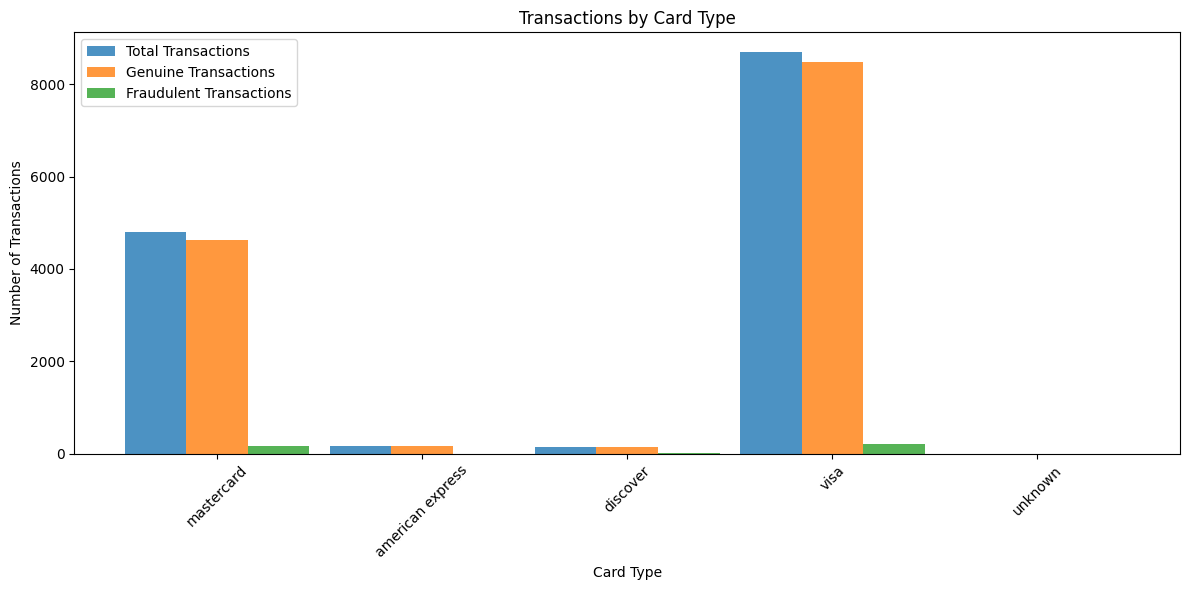

In [ ]:
#Plots the card data

card_stats_pd = card_stats.toPandas()
card_types = card_stats_pd['card4']
total_transactions = card_stats_pd['number_of_transactions']
genuine_transactions = card_stats_pd['genuine_transactions']
fraudulent_transactions = card_stats_pd['fraudulent_transactions']


x = np.arange(len(card_types))
width = 0.3


plt.figure(figsize=(12, 6))
plt.bar(x - width, total_transactions, width, label='Total Transactions', alpha=0.8)
plt.bar(x, genuine_transactions, width, label='Genuine Transactions', alpha=0.8)
plt.bar(x + width, fraudulent_transactions, width, label='Fraudulent Transactions', alpha=0.8)

plt.xlabel("Card Type")
plt.ylabel("Number of Transactions")
plt.title("Transactions by Card Type")
plt.xticks(x, card_types, rotation=45)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


#**2. Alogorithms**

In [ ]:
# Algorithm 1- Naive Bayes


indexers = [StringIndexer(inputCol=column, outputCol=f"{column}_index") for column in string_columns]
indexed_string_columns = [f"{column}_index" for column in string_columns]

feature_columns = int_columns + indexed_string_columns
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="keep")

pipeline = Pipeline(stages=indexers + [assembler])
pipeline_model = pipeline.fit(transactions_df)

prepared_data = pipeline_model.transform(transactions_df)
prepared_data = prepared_data.select(col("isFraud").alias("label"), col("features"))

NB_train_data, NB_test_data = prepared_data.randomSplit([0.8, 0.2], seed=123)

nb = NaiveBayes(featuresCol="features", labelCol="label", predictionCol="prediction")
nb_model = nb.fit(NB_train_data)
NB_predictions = nb_model.transform(NB_test_data)
NB_predictions.select(
    col("label").alias("Actual"),
    col("prediction").alias("Predicted"),
    "features"
).show(20, truncate=False)


+------+---------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
 # Algorithm 2- Artificia Neural Network


indexers = [StringIndexer(inputCol=column, outputCol=f"{column}_index") for column in string_columns]
indexed_string_columns = [f"{column}_index" for column in string_columns]


feature_columns = int_columns + indexed_string_columns
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")


pipeline = Pipeline(stages=indexers + [assembler])
pipeline_model = pipeline.fit(transactions_df)
prepared_data = pipeline_model.transform(transactions_df)


prepared_data = prepared_data.select(col("isFraud").alias("label"), col("features"))


input_features = len(feature_columns)
layers = [input_features, 64, 32, 2]


ANN_train_data,ANN_test_data = prepared_data.randomSplit([0.8, 0.2], seed=123)


ANN = MultilayerPerceptronClassifier(featuresCol="features", labelCol="label", predictionCol="prediction", layers=layers, maxIter=100)
ANN_model = ANN.fit(ANN_train_data)

ann_predictions = ANN_model.transform(ANN_test_data)
ann_predictions.select(
     col("label").alias("Actual"),
     col("prediction").alias("Predicted"),
     "features"
 ).show(20, truncate=False)

+------+---------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Algorithm 3: Random Forest

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(prepared_data)
scaled_data = scaler_model.transform(prepared_data)

train_data, test_data = scaled_data.randomSplit([0.8, 0.2], seed=123)

indexers = [StringIndexer(inputCol=column, outputCol=f"{column}_index") for column in string_columns]
indexed_string_columns = [f"{column}_index" for column in string_columns]


feature_columns = int_columns + indexed_string_columns
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")


pipeline = Pipeline(stages=indexers + [assembler])
pipeline_model = pipeline.fit(transactions_df)
prepared_data = pipeline_model.transform(transactions_df)


prepared_data = prepared_data.select(col("isFraud").alias("label"), col("features"))


input_features = len(feature_columns)
layers = [input_features, 64, 32, 2]


RF_train_data, RF_test_data = scaled_data.randomSplit([0.8, 0.2], seed=123)


rf = RandomForestClassifier(featuresCol="scaledFeatures", labelCol="label", predictionCol="prediction", numTrees=50)
rf_model = rf.fit(RF_train_data)

rf_predictions = rf_model.transform(RF_test_data)
rf_predictions.select(
     col("label").alias("Actual"),
     col("prediction").alias("Predicted"),
     "features"
 ).show(20, truncate=False)

+------+---------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Algorithm 4: Gradient Boost
string_columns = ["ProductCD", "card4", "card6", "P_emaildomain", "R_emaildomain"]
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="skip") for col in string_columns]

numeric_columns = [field.name for field in transactions_df.schema.fields if isinstance(field.dataType, (IntegerType, DoubleType, FloatType))]
indexed_string_columns = [f"{col}_index" for col in string_columns]
feature_columns = numeric_columns + indexed_string_columns

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

pipeline = Pipeline(stages=indexers + [assembler])
pipeline_model = pipeline.fit(transactions_df)
prepared_data = pipeline_model.transform(transactions_df)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(prepared_data)
scaled_data = scaler_model.transform(prepared_data)

prepared_data = scaled_data.select(col("isFraud").alias("label"), col("scaledFeatures").alias("features"))

gbt_train_data, gbt_test_data = prepared_data.randomSplit([0.8, 0.2], seed=123)


gbt = GBTClassifier(featuresCol="features", labelCol="label", predictionCol="prediction", maxIter=50, maxDepth=5, stepSize=0.1)
gbt_model = gbt.fit(gbt_train_data)

gbt_predictions = gbt_model.transform(gbt_test_data)


gbt_predictions.select(
    col("label").alias("Actual"),
    col("prediction").alias("Predicted"),
    "features"
).show(20, truncate=False)



+------+---------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#**3.Evaluation and Comparison**

In [ ]:
# Evaluation of Naive Bayes Classifier

#Accuracy and Error rarte
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
nb_accuracy = evaluator.evaluate(NB_predictions)
nb_error_rate = 1 - nb_accuracy

#ROC and AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="probability", metricName="areaUnderROC")
nb_roc_auc = binary_evaluator.evaluate(NB_predictions)

#Speed
start_train = time.time()
nb_model = nb.fit(NB_train_data)
end_train = time.time()
nb_training_time = end_train - start_train

start_predict = time.time()
NB_predictions = nb_model.transform(NB_test_data)
end_predict = time.time()
nb_prediction_time = end_predict - start_predict

nb_total_time = nb_training_time + nb_prediction_time


print("Naive Bayes Model Evaluation")
print("--------------------")
print(f"Accuracy: {nb_accuracy:.4f}")
print(f"Error Rate: {nb_error_rate:.4f}")
print(f"ROC AUC: {nb_roc_auc:.4f}")
print(f"Training Time: {nb_training_time:.4f} seconds")
print(f"Prediction Time: {nb_prediction_time:.4f} seconds")
print(f"Total Speed (Training + Prediction): {nb_total_time:.4f} seconds")

Naive Bayes Model Evaluation
--------------------
Accuracy: 0.8318
Error Rate: 0.1682
ROC AUC: 0.5988
Training Time: 20.3109 seconds
Prediction Time: 2.3306 seconds
Total Speed (Training + Prediction): 22.6415 seconds


In [ ]:
# Evaluation of Artifical Neural Network

#Accuracy and Error rarte
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
ann_accuracy = evaluator.evaluate(ann_predictions)
ann_error_rate = 1 - ann_accuracy

#ROC and AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="probability", metricName="areaUnderROC")
ann_roc_auc = binary_evaluator.evaluate(ann_predictions)

#Speed
start_train = time.time()
ANN_model = ANN.fit(ANN_train_data)
end_train = time.time()
ann_training_time = end_train - start_train

start_predict = time.time()
ANN_predictions = ANN_model.transform(ANN_test_data)
end_predict = time.time()
ann_prediction_time = end_predict - start_predict

ann_total_time = ann_training_time + ann_prediction_time

print("ANN Model Evaluation")
print("--------------------")
print(f"Accuracy: {ann_accuracy:.4f}")
print(f"Error Rate: {ann_error_rate:.4f}")
print(f"ROC AUC: {ann_roc_auc:.4f}")
print(f"Training Time: {ann_training_time:.4f} seconds")
print(f"Prediction Time: {ann_prediction_time:.4f} seconds")
print(f"Total Speed (Training + Prediction): {ann_total_time:.4f} seconds")

ANN Model Evaluation
--------------------
Accuracy: 0.9686
Error Rate: 0.0314
ROC AUC: 0.6959
Training Time: 103.2903 seconds
Prediction Time: 3.8869 seconds
Total Speed (Training + Prediction): 107.1772 seconds


In [ ]:
# Evaluation Random Forest

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
rf_accuracy = evaluator.evaluate(rf_predictions)
rf_error_rate = 1 - rf_accuracy

#ROC and AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="probability", metricName="areaUnderROC")
rf_roc_auc = binary_evaluator.evaluate(rf_predictions)

# Speed Evaluation for Random Forest
start_train_rf = time.time()
rf_model = rf.fit(train_data)
end_train_rf = time.time()
rf_training_time = end_train_rf - start_train_rf

start_predict_rf = time.time()
rf_predictions = rf_model.transform(test_data)
end_predict_rf = time.time()
rf_prediction_time = end_predict_rf - start_predict_rf

rf_total_time = rf_training_time + rf_prediction_time

print("Random Forest Evaluation")
print("--------------------")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Error Rate: {rf_error_rate:.4f}")
print(f"ROC AUC: {rf_roc_auc:.4f}")
print(f"Training Time: {rf_training_time:.4f} seconds")
print(f"Prediction Time: {rf_prediction_time:.4f} seconds")
print(f"Total Speed (Training + Prediction): {rf_total_time:.4f} seconds")

Random Forest Evaluation
--------------------
Accuracy: 0.9726
Error Rate: 0.0274
ROC AUC: 0.8290
Training Time: 50.3263 seconds
Prediction Time: 2.3817 seconds
Total Speed (Training + Prediction): 52.7080 seconds


In [ ]:
# Evaluation for Gradient Boaost

#Accuracy and Error rarte
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
gbt_accuracy = evaluator.evaluate(gbt_predictions)
gbt_error_rate = 1 - gbt_accuracy

#ROC and AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="probability", metricName="areaUnderROC")
gbt_roc_auc = binary_evaluator.evaluate(gbt_predictions)

#Speed
start_train = time.time()
gbt_model = nb.fit(gbt_train_data)
end_train = time.time()
gbt_training_time = end_train - start_train

start_predict = time.time()
gbt_predictions = nb_model.transform(gbt_test_data)
end_predict = time.time()
gbt_prediction_time = end_predict - start_predict

gbt_total_time = gbt_training_time + gbt_prediction_time


print("Gradient Boost Model Evaluation")
print("--------------------")
print(f"Accuracy: {gbt_accuracy:.4f}")
print(f"Error Rate: {gbt_error_rate:.4f}")
print(f"ROC AUC: {gbt_roc_auc:.4f}")
print(f"Training Time: {gbt_training_time:.4f} seconds")
print(f"Prediction Time: {gbt_prediction_time:.4f} seconds")
print(f"Total Speed (Training + Prediction): {gbt_total_time:.4f} seconds")

Gradient Boost Model Evaluation
--------------------
Accuracy: 1.0000
Error Rate: 0.0000
ROC AUC: 1.0000
Training Time: 20.4136 seconds
Prediction Time: 2.9130 seconds
Total Speed (Training + Prediction): 23.3266 seconds


In [ ]:
# Model Comparison
comparison_data = {
    "Model": ["Naive Bayes", "ANN", "Random Forest", "Garadient Boost"],
    "Accuracy": [nb_accuracy, ann_accuracy, rf_accuracy, gbt_accuracy],
    "Error Rate": [nb_error_rate, ann_error_rate, rf_error_rate, gbt_error_rate],
    "ROC AUC": [nb_roc_auc, ann_roc_auc, rf_roc_auc, gbt_roc_auc],
    "Training Time (s)": [nb_training_time, ann_training_time, rf_training_time, gbt_training_time],
    "Prediction Time (s)": [nb_prediction_time, ann_prediction_time, rf_prediction_time, gbt_prediction_time],
    "Total Time (s)": [nb_total_time, ann_total_time, rf_total_time, gbt_total_time],
}

comparison_df = pd.DataFrame(comparison_data)

print("Model Comparison:")
comparison_df

Model Comparison:


,Model,Accuracy,Error Rate,ROC AUC,Training Time (s),Prediction Time (s),Total Time (s)
0,Naive Bayes,0.831849,0.168151,0.598816,20.310867,2.330607,22.641474
1,ANN,0.968650,0.031350,0.695888,103.290294,3.886867,107.177160
2,Random Forest,0.972569,0.027431,0.828962,50.326273,2.381699,52.707972
3,Garadient Boost,1.000000,0.000000,1.000000,20.413595,2.913043,23.326637
